## Data Mining

Chan Pei Shan 17198798

Too Ai Leng 17201119

In [ ]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import random
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import average_precision_score
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_precision_recall_curve

In [ ]:
train_identity = pd.read_csv(f'train_identity.csv')
train_transaction = pd.read_csv(f'train_transaction.csv')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Exploratory data Analysis

In [ ]:
list_num = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11']
list_cat = []
for i in range(12,39):
    a='id_'+str(i)
    list_cat.append(a)
numerical = train.filter(regex='^C|dist|^D[0-9]{1,3}$|^M|^V',axis=1)
numerical[list_num]=train.loc[:,list_num]
categorical = train.filter(regex='^card|^addr|emaildomain|Device',axis=1)
categorical[list_cat]=train.loc[:,list_cat]

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)


Text(0.04, 0.5, 'count')

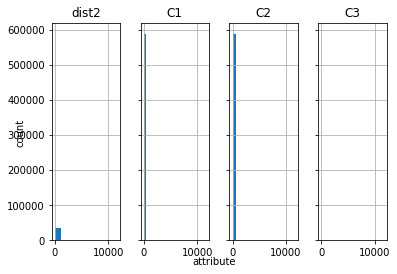

In [ ]:
a=[1,2,3,4]
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
numerical.hist(column=numerical.columns[a], ax=axes)
fig.text(0.5, 0.04, 'attribute', ha='center')
fig.text(0.04, 0.5, 'count', va='center', rotation='vertical')

In [ ]:
a=[0,1,2,3]
categorical[categorical.columns[a]].plot.bar(subplots=True)

## Feature Engineering

In [ ]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')
train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')
train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)

## Prepare data for modelling

1. Data Cleaning - drop columns and rows with too many missing values

In [ ]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
cols_to_drop = list(set(many_null_cols  + big_top_value_cols + one_value_cols))
cols_to_drop.remove('isFraud')
train = train.drop(cols_to_drop, axis=1)

def get_too_many_null_attr(data):
    ccols = [x for x in data.columns if data[x].isnull().sum() / data.shape[0] > 0.70]
    return ccols
cl = get_too_many_null_attr(train)
train = train.drop(columns = cl)
train = train.dropna(axis=0, thresh=train.shape[1]*0.9)

In [ ]:
train.shape

(255727, 186)

## Data Cleaning 2

- We replaced missing values with -1 in category variables
- category variables are then label encoded.
- Impute numerical smissing values with mode

In [ ]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
train = train.replace([np.inf, -np.inf], np.nan)
def clean_nan(df):
    for col in cat_cols:
        return df.replace(['None', np.nan], '-1')  
train = clean_nan(train)
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
from sklearn.impute import SimpleImputer
im = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cols = list(train.columns)
train = pd.DataFrame(im.fit_transform(train.astype('float')), columns=cols)

#### Note  that fraud data and non-fraud data have a very huge difference.

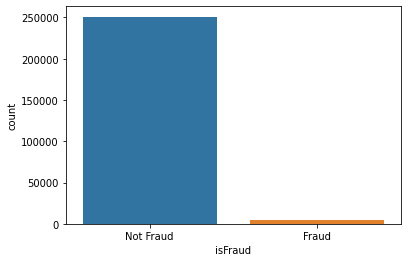

In [ ]:
g = sns.countplot(train['isFraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

## Balancing Data
- fraud data: about 4k
- get 4k non-fraud data


In [ ]:
df = train
df2 = df.loc[df['isFraud']==0].sample(n=4000,random_state=1234)
df2 = df2.append(df[df['isFraud']==1])

# Dimension Reduction
- Drop by low varience
- Drop by high correlation

In [ ]:
x = df2.drop(['isFraud','TransactionID','TransactionDT'],axis=1)
y = df2.isFraud

# Drop by low varience
varience = x.var().sort_values()
x.drop(list(varience[varience==0].index),axis=1,inplace=True)
# Drop by high correlation
cor_matrix = x.corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,C1,C2,C5,C6,C9,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,...,V100,V126,V127,V128,V130,V131,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2
TransactionAmt,NaN,-0.002502,0.091554,0.000071,-0.080294,-0.063551,-0.267666,-0.032313,0.020241,-0.046700,-0.058062,-0.063026,-0.055672,-0.061311,-0.066347,-0.056695,-0.029118,-0.083002,-0.068987,-0.100285,-0.104218,-0.036142,-0.112723,-0.030481,-0.108905,-0.119725,-0.127131,-0.003898,-0.012833,0.009940,-0.009573,-0.017286,0.085596,0.098899,0.059848,0.077648,-0.001738,-0.000234,-0.012936,0.019780,...,-0.048819,0.272241,0.226990,0.278337,0.148443,0.204156,-0.007323,-0.009559,0.079598,0.034256,-0.089678,-0.052567,0.008859,-0.020323,-0.035814,-0.005472,-0.015609,0.257050,0.231474,0.274117,0.180320,0.238030,0.290392,0.249877,0.278838,0.193715,0.871608,0.979437,0.326667,0.982248,-0.119489,-0.123624,-0.083310,-0.125483,-0.126514,-0.127131,-0.127132,-0.127131,-0.048369,0.155448
card1,NaN,NaN,-0.094619,-0.013466,-0.019260,0.023590,-0.012476,-0.059692,-0.025430,0.055432,0.025106,0.020922,0.022737,0.033044,0.023377,0.021705,-0.014723,0.035140,0.021663,-0.036032,-0.023754,-0.009286,-0.004427,-0.017316,0.016727,0.007241,0.002660,-0.010152,0.029750,0.017644,-0.015782,-0.006430,0.047854,0.027892,0.028318,0.031910,0.023714,0.002723,-0.028361,0.007853,...,0.023018,0.004080,0.024180,0.012750,0.069936,0.046213,-0.003275,-0.018899,-0.049859,-0.060248,0.038102,0.009368,-0.011906,-0.051872,-0.029833,-0.023975,-0.015667,-0.015682,-0.014317,-0.019356,0.043525,0.028199,0.021332,-0.000686,0.007214,-0.019520,0.003330,-0.013964,-0.008388,-0.010879,-0.002666,-0.000456,0.005449,-0.000617,0.011511,0.002660,0.005688,0.002660,0.056823,-0.002062
card2,NaN,NaN,NaN,0.085102,0.119299,0.099957,-0.107205,0.083306,-0.027849,-0.035882,-0.020578,-0.012306,-0.016812,-0.016040,-0.009929,-0.018623,0.016871,-0.019203,-0.017553,-0.013867,-0.028879,-0.012116,-0.031839,-0.020900,-0.031894,-0.047771,-0.028366,0.025098,-0.017291,-0.006308,0.049943,0.043804,0.015202,0.023392,0.005127,0.021017,-0.010972,0.017088,0.072621,0.010442,...,0.019212,0.068392,0.041256,0.071519,0.002678,0.038263,0.060452,0.095631,0.108950,0.133829,0.019338,0.046705,0.034520,0.082507,0.113601,0.099581,0.086837,0.091304,0.095292,0.111491,0.039729,0.072526,0.074747,0.102582,0.093130,0.086243,0.044476,0.107726,0.058951,0.109880,-0.025563,-0.020561,0.017813,-0.018412,-0.035575,-0.028366,-0.030342,-0.028366,-0.039056,0.048884
card3,NaN,NaN,NaN,NaN,0.246358,0.123758,0.197644,0.000596,0.014493,0.007001,0.007232,0.007118,0.005988,0.006583,0.005659,0.006457,0.012993,0.005315,0.005831,-0.011052,-0.013620,0.000084,-0.034267,-0.001292,-0.004861,-0.028850,-0.020963,-0.001443,-0.012764,0.003616,0.017382,0.000799,0.026915,-0.027269,-0.018567,-0.020801,-0.002562,0.004224,0.013547,-0.002249,...,0.012385,0.006402,0.006234,0.010406,-0.009621,-0.001220,0.017427,0.017051,0.019750,0.012891,0.005594,0.015420,0.012326,0.011649,0.005663,0.011023,0.013850,0.009912,0.007435,0.010271,-0.004798,0.006620,0.006177,0.002437,0.008302,0.010345,-0.001191,0.058266,-0.000452,0.076373,-0.015963,0.084541,-0.004468,0.094646,-0.021042,-0.020963,-0.021279,-0.020963,0.007111,0.009257
card4,NaN,NaN,NaN,NaN,NaN,0.578901,0.254515,0.065432,0.013198,0.004226,0.010921,0.012661,0.002298,0.007387,0.013455,0.007192,-0.002761,0.019903,0.008060,0.036597,0.027602,0.018978,0.021393,0.006521,0.032830,0.055985,0.039456,-0.015425,0.002137,0.009994,-0.041052,-0.024678,0.043661,-0.047094,-0.026696,-0.017073,-0.022448,-0.021509,0.018836,-0.043311,...,0.011034,-0.030786,-0.055607,-0

In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.4)]
x.drop(to_drop,axis=1,inplace=True)
#Standardize
x_std=StandardScaler().fit_transform(x)

## Split dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2, random_state=1234)

# Feature Extraction
- PCA

In [ ]:
#PCA
from sklearn.decomposition import PCA
pca_train = PCA().fit(x_train)
x_values = range(1, pca_train.n_components_+1)

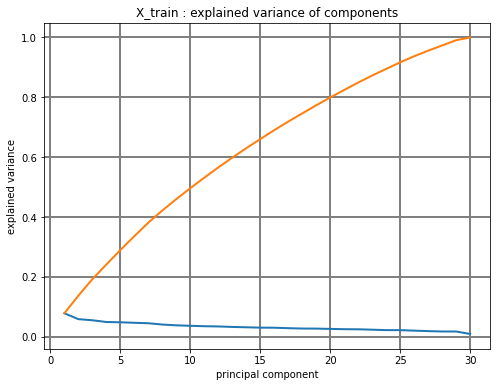

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_values, 
        pca_train.explained_variance_ratio_, 
        lw=2, 
        label='explained variance')
ax.plot(x_values, 
        np.cumsum(pca_train.explained_variance_ratio_), 
        lw=2, 
        label='cumulative explained variance')
ax.grid(color='grey', linestyle='-', linewidth=2)
ax.set_title('X_train : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()
pca = PCA(.95).fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

# Modeling

1. Random Forest

In [ ]:
#RandomForest
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
rf_classifier = rf_classifier.fit(x_train, y_train)
rf_pred       = rf_classifier.predict(x_test)
print(confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))
print('randomforest accuracy: '+str(accuracy_score(y_test, rf_pred)))

[[601 200]
 [137 846]]
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       801
         1.0       0.81      0.86      0.83       983

    accuracy                           0.81      1784
   macro avg       0.81      0.81      0.81      1784
weighted avg       0.81      0.81      0.81      1784

randomforest accuracy: 0.8110986547085202


## Linear Regression

In [ ]:
#linear regression
log_model = LogisticRegression()
log_model = log_model.fit(x_train, y_train)
log_pred = log_model.predict(x_test)
print(confusion_matrix(y_test,log_pred))
print(classification_report(y_test,log_pred))
print('regression accuracy: '+str(accuracy_score(y_test, log_pred)))

[[480 321]
 [206 777]]
              precision    recall  f1-score   support

         0.0       0.70      0.60      0.65       801
         1.0       0.71      0.79      0.75       983

    accuracy                           0.70      1784
   macro avg       0.70      0.69      0.70      1784
weighted avg       0.70      0.70      0.70      1784

regression accuracy: 0.7045964125560538


array([0.32842305, 0.49781895, 0.58199729, ..., 0.73273373, 0.74839116,
       0.47557217])

## Naive Bayes

In [ ]:
#naive bayes
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train, y_train)
nb_pred  = nb_model.predict(x_test)
y_score_nb = nb_model.predict_proba(x_test)[:,-1]
print(confusion_matrix(y_test,nb_pred))
print(classification_report(y_test,nb_pred))
print('naive bayes accuracy: '+str(accuracy_score(y_test, nb_pred)))

[[582 219]
 [364 619]]
              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67       801
         1.0       0.74      0.63      0.68       983

    accuracy                           0.67      1784
   macro avg       0.68      0.68      0.67      1784
weighted avg       0.68      0.67      0.67      1784

naive bayes accuracy: 0.6732062780269058


## Decision Tree

In [ ]:
#decision tree
dt_model = DecisionTreeClassifier(random_state=0)
dt_model = dt_model.fit(x_train, y_train)
dt_pred  = dt_model.predict(x_test)
print(confusion_matrix(y_test,dt_pred))
print(classification_report(y_test,dt_pred))
print('decision tree accuracy: '+str(accuracy_score(y_test, dt_pred)))

[[517 284]
 [270 713]]
              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65       801
         1.0       0.72      0.73      0.72       983

    accuracy                           0.69      1784
   macro avg       0.69      0.69      0.69      1784
weighted avg       0.69      0.69      0.69      1784

decision tree accuracy: 0.6894618834080718


## SVM

In [ ]:
svm_model = svm.SVC(kernel='linear', probability=True)
svm_model = svm_model.fit(x_train, y_train)
pred  = svm_model.predict(x_test)
print(confusion_matrix(y_test,svm_pred))
print(classification_report(y_test,svm_pred))
print('svm accuracy: '+str(accuracy_score(y_test, svm_pred)))

[[422 379]
 [152 831]]
              precision    recall  f1-score   support

         0.0       0.74      0.53      0.61       801
         1.0       0.69      0.85      0.76       983

    accuracy                           0.70      1784
   macro avg       0.71      0.69      0.69      1784
weighted avg       0.71      0.70      0.69      1784

svm accuracy: 0.702354260089686


## precision - recall curve

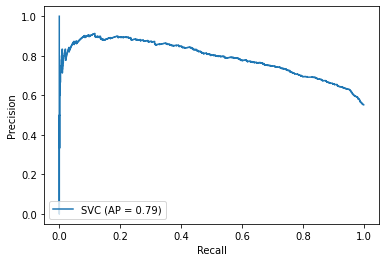

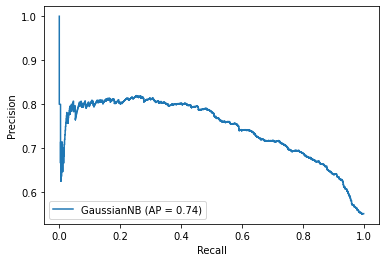

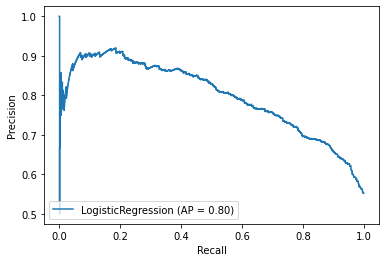

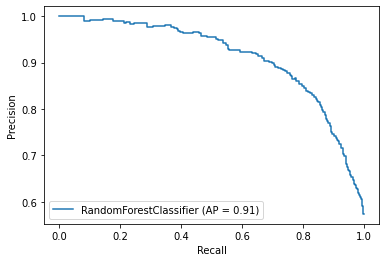

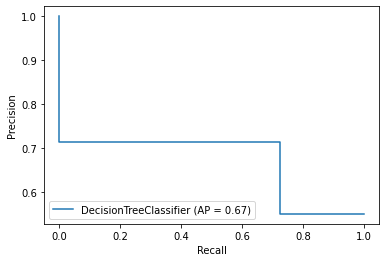

In [ ]:
plot_precision_recall_curve(svm_model, x_test, y_test)
plot_precision_recall_curve(nb_model, x_test, y_test)
plot_precision_recall_curve(log_model, x_test, y_test)
plot_precision_recall_curve(rf_classifier, x_test, y_test)
plot_precision_recall_curve(dt_model, x_test, y_test)